In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import tensorflow
import parquet
import seaborn as sns

In [2]:
#!pip install pandasql
#!pip install tensorflow
#!pip install parquet
#!pip install Scikit-learn

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# DATA PREPARATION

# START TRAINING FROM HERE

In [21]:
df = pd.read_parquet('kelusanka_2022_after imputing_missing.parquet')
len(df)

4745

In [22]:
hourly_train,hourly_test = df[['DEMAND']].iloc[:4342],df[['DEMAND']].iloc[4342:]
#hourly_train,hourly_test
print(len(hourly_train),len(hourly_test))

4342 403


In [23]:
scaler = MinMaxScaler()
scaler.fit(hourly_train)
scaled_hourly_train = scaler.transform(hourly_train)
scaled_hourly_test = scaler.transform(hourly_test)
len(scaled_hourly_train)

4342

In [15]:
scaled_hourly_train

array([[0.11637931],
       [0.29741379],
       [0.09051724],
       ...,
       [0.56465517],
       [0.60775862],
       [0.06465517]])

In [21]:
n_input_hourly = 4
n_features = 1
def train_data_hourly(a,n):
    R,s=[],[]
    for i in range(len(scaled_hourly_train)):
        end_ix = i + n_input_hourly
        if end_ix > len(scaled_hourly_train)-1:
            break
        seq_r,seq_s = scaled_hourly_train[i:end_ix],scaled_hourly_train[end_ix]
        R.append(seq_r)
        s.append(seq_s)
    return np.array(R),np.array(s)
R,s = train_data_hourly(scaled_hourly_train,n_input_hourly)
R_train,R_val,s_train,s_val =train_test_split(R,s,test_size=0.15,shuffle = False,random_state = 0)

In [67]:
### defining hourly model
model1 =Sequential()
model1.add(LSTM(128,activation ='relu',input_shape=(n_input_hourly,n_features),return_sequences=True))#return sequence when more than one layer
#return sequence is used for first two layers to ensure that the output of each layer is fed into the next layer
#in the sequence
##model1.add(Dropout(0.2))
#Droupout regularization is used for preventing overfitting in LSTM layers
model1.add(LSTM(64,return_sequences=True))
##model1.add(Dropout(0.2))
model1.add(LSTM(16))
model1.add(Dense(1))

In [68]:
#model compiling
model1.compile(optimizer = 'adam',loss = 'mse')
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_22 (LSTM)              (None, 4, 64)             49408     
                                                                 
 lstm_23 (LSTM)              (None, 16)                5184      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 121,169
Trainable params: 121,169
Non-trainable params: 0
_________________________________________________________________


In [17]:
model1.fit(R,s, epochs=120 ,batch_size = 32 )

In [74]:
#model1.save('kelu_2022.h5')

In [18]:
model1 = load_model('kelu_2022_best.h5')
#25 mape 120 epoch n_input_hourly = 4, batch_size = 32

In [19]:
model1.evaluate(R,s,verbose = 2)

136/136 - 1s - loss: 0.0090 - 1s/epoch - 8ms/step


0.009024569764733315

# HOURLY TESTING BY PREDICTION

In [22]:
#output test
last_train_batch = scaled_hourly_train[-n_input_hourly:]
last_train_batch = last_train_batch.reshape(1,n_input_hourly,n_features)
last_train_batch,model1.predict(last_train_batch)

1/1 [==============================] - 1s 611ms/step


(array([[[0.48706897],
         [0.56465517],
         [0.60775862],
         [0.06465517]]]),
 array([[0.22881445]], dtype=float32))

In [23]:
scaled_hourly_test[0]

array([0.26293103])

In [24]:
hourly_predictions = []
first_eval_batch = scaled_hourly_train[-n_input_hourly:]
current_batch = first_eval_batch.reshape(1,n_input_hourly,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model1.predict(current_batch)[0]
    
    # appending the prediction into array
    hourly_predictions.append(current_pred)
    
    #updating the batch with the predicted value and removing the first element
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)
    
hourly_predictions

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


[array([0.22881445], dtype=float32),
 array([0.6021005], dtype=float32),
 array([0.25787342], dtype=float32),
 array([0.13292077], dtype=float32),
 array([0.2676056], dtype=float32),
 array([0.26928174], dtype=float32),
 array([0.10542782], dtype=float32),
 array([0.1429402], dtype=float32),
 array([0.32380906], dtype=float32),
 array([0.47977075], dtype=float32),
 array([0.54184127], dtype=float32),
 array([0.46580383], dtype=float32),
 array([0.03432827], dtype=float32),
 array([0.29006553], dtype=float32),
 array([0.6449732], dtype=float32),
 array([0.23083502], dtype=float32),
 array([0.13330165], dtype=float32),
 array([0.24049276], dtype=float32),
 array([0.22767559], dtype=float32),
 array([0.11828438], dtype=float32),
 array([0.11145318], dtype=float32),
 array([0.29283825], dtype=float32),
 array([0.4170402], dtype=float32),
 array([0.5084211], dtype=float32),
 array([0.51319003], dtype=float32),
 array([0.06363031], dtype=float32),
 array([0.23535822], dtype=float32),
 array(

In [25]:
scaled_hourly_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_hourly_test2 = pd.DataFrame(scaled_hourly_test1)
true_predictions = scaler.inverse_transform(hourly_predictions)
scaled_hourly_test2['predictions'] = np.round(true_predictions)
scaled_hourly_test2

,0,predictions
0,62.0,54.0
1,162.0,141.0
2,63.0,61.0
3,26.0,32.0
4,59.0,63.0
...,...,...
398,75.0,74.0
399,90.0,112.0
400,106.0,125.0
401,138.0,110.0


rmse: 23.31960484706645
mape: 25.460489233562477
wmape: 22.183813269060003


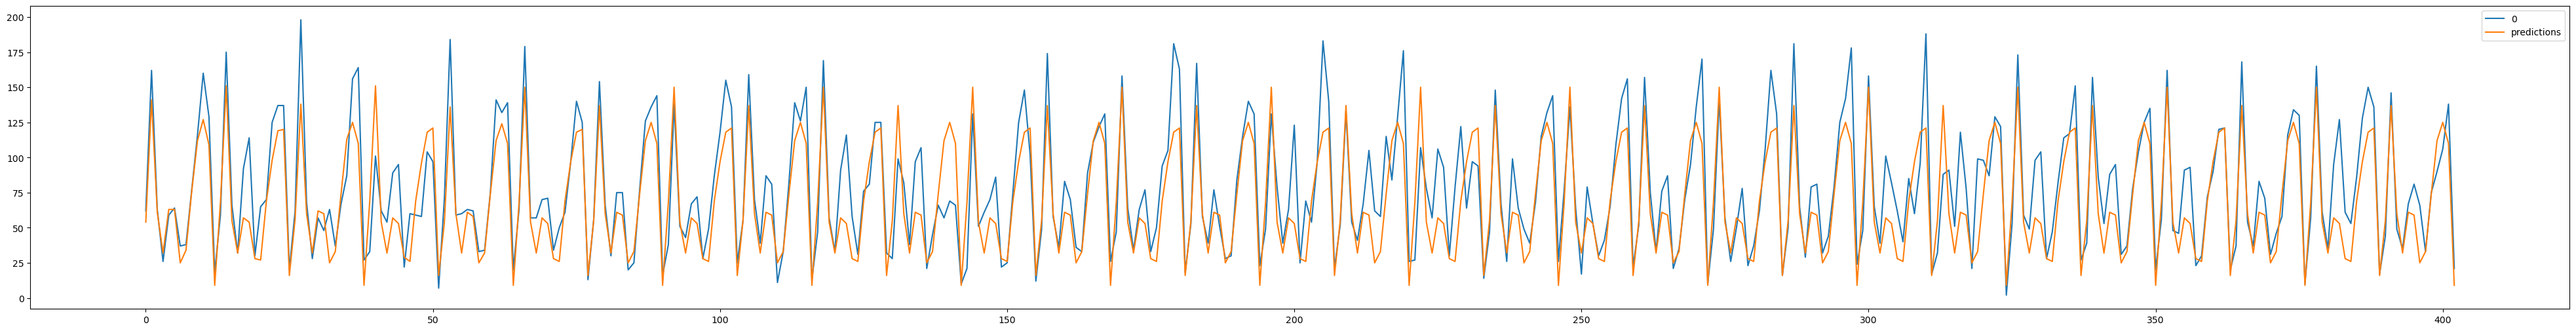

In [26]:
scaled_hourly_test2.plot(kind = 'line',figsize =(50,6))
rmse = sqrt(mean_squared_error(scaled_hourly_test2[0],scaled_hourly_test2['predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(scaled_hourly_test2))*np.sum(np.abs((scaled_hourly_test2[0]-scaled_hourly_test2['predictions'])/scaled_hourly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_hourly_test2[0]/np.sum(scaled_hourly_test2[0]))*(np.abs((scaled_hourly_test2[0]-scaled_hourly_test2['predictions'])/scaled_hourly_test2[0])))*100
print('wmape:',wmape)

In [45]:
#model1.save('kelu_2022_best.h5')
#25 mape 120 epoch n_input_hourly = 4, batch_size = 25

# DAILY PERIODICITY

In [44]:
n_input_daily = 7
n_features = 1
def daily_train_data(a,n):
    X,y=[],[]
    for i in range(len(a)-13):
        end_ix = i +13*n
        if end_ix > len(a)-1:
            break
        seq_x,seq_y = [a[i+13*j] for j in range(n)],a[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)
X,y = daily_train_data(scaled_hourly_train,n_input_daily)

In [45]:
X[0],y[0]

(array([[0.11637931],
        [0.08189655],
        [0.44396552],
        [0.34913793],
        [0.38362069],
        [0.43103448],
        [0.4137931 ]]),
 array([0.0387931]))

In [46]:
scaled_hourly_train[39]

array([0.34913793])

In [47]:
len(X),len(y),X.shape

(4251, 4251, (4251, 7, 1))

In [48]:
X_train,X_val,y_train,y_val =train_test_split(X,y,test_size=0.2,shuffle = False,random_state = 0)
len(X_train),len(X_val),len(y_train),len(y_val)

(3400, 851, 3400, 851)

In [53]:
### defining daily model
model2 =Sequential()
model2.add(LSTM(128,activation ='relu',input_shape=(n_input_daily,n_features),return_sequences=True))#return sequence when more than one layer
##model2.add(Dropout(0.2))
model2.add(LSTM(64,return_sequences=True))
##model2.add(Dropout(0.2))
model2.add(LSTM(16))
model2.add(Dense(1))

In [54]:
#model compiling
model2.compile(optimizer = 'adam',loss = 'mse')
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 7, 128)            66560     
                                                                 
 lstm_16 (LSTM)              (None, 7, 64)             49408     
                                                                 
 lstm_17 (LSTM)              (None, 16)                5184      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 121,169
Trainable params: 121,169
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0057 - val_loss: 0.0085
Epoch 2/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0058 - val_loss: 0.0082
Epoch 3/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0056 - val_loss: 0.0081
Epoch 4/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0056 - val_loss: 0.0081
Epoch 5/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0056 - val_loss: 0.0082
Epoch 6/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0056 - val_loss: 0.0082
Epoch 7/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0057 - val_loss: 0.0083
Epoch 8/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 9/100
107/107 [==============================] - 1s 9ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 10/100
107/107 [==============================] - 1s 9ms/step - loss: 0.0056 - val_lo

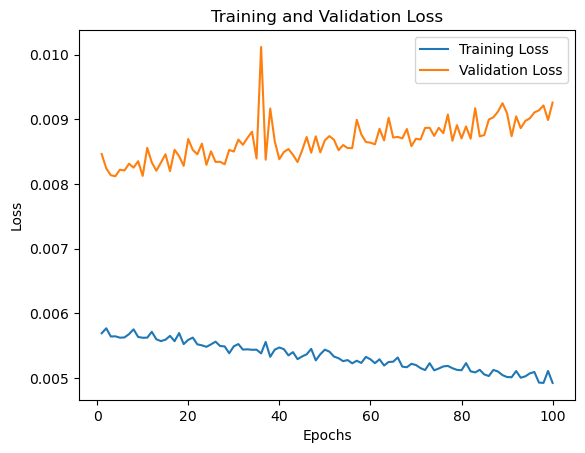

In [57]:
model2.fit(X_train,y_train,validation_data = (X_val,y_val),epochs =100,batch_size = 32)#250

In [354]:
#model2.save('daily_training.h5')

In [49]:
model2 = load_model('daily_training.h5')
#24% mape 230 epochs,n_input_daily=7,batch_size = 100

# Daily periodicity prediction

In [50]:
first_prediction_set = scaled_hourly_train[len(X):]
first_prediction_set

array([[0.36637931],
       [0.71982759],
       [0.28017241],
       [0.15517241],
       [0.22844828],
       [0.32758621],
       [0.06896552],
       [0.20258621],
       [0.34051724],
       [0.54310345],
       [0.52586207],
       [0.52155172],
       [0.06034483],
       [0.23706897],
       [0.75862069],
       [0.34913793],
       [0.17241379],
       [0.30603448],
       [0.30603448],
       [0.15948276],
       [0.12068966],
       [0.28017241],
       [0.40517241],
       [0.54310345],
       [0.6637931 ],
       [0.09913793],
       [0.21982759],
       [0.68534483],
       [0.19827586],
       [0.125     ],
       [0.22413793],
       [0.43534483],
       [0.21551724],
       [0.13362069],
       [0.26293103],
       [0.51293103],
       [0.59913793],
       [0.625     ],
       [0.10775862],
       [0.18965517],
       [0.43534483],
       [0.40948276],
       [0.1637931 ],
       [0.42672414],
       [0.2887931 ],
       [0.12931034],
       [0.22844828],
       [0.262

In [51]:
def training_batch(a):
    first_predict_batch = []
    for i in range(n_input_daily):
        first_predict_batch.append(list(a[13*i]))
    first_predict_batch =np.array(first_predict_batch)
    return first_predict_batch

In [52]:
daily_predictions = []
train_batch = training_batch(first_prediction_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model2.predict(current_batch)[0]
    
    # appending the prediction into array
    daily_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    first_prediction_set = np.append(first_prediction_set[1:],current_pred)
    updated_prediction_set = first_prediction_set[:, np.newaxis]
    train_batch = training_batch(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)
    
daily_predictions

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


[array([0.2619832], dtype=float32),
 array([0.6884013], dtype=float32),
 array([0.32476512], dtype=float32),
 array([0.15966782], dtype=float32),
 array([0.35852942], dtype=float32),
 array([0.3061906], dtype=float32),
 array([0.11442338], dtype=float32),
 array([0.1702176], dtype=float32),
 array([0.29223683], dtype=float32),
 array([0.5083883], dtype=float32),
 array([0.56504285], dtype=float32),
 array([0.597691], dtype=float32),
 array([0.0661554], dtype=float32),
 array([0.23467255], dtype=float32),
 array([0.68277735], dtype=float32),
 array([0.3179618], dtype=float32),
 array([0.16005874], dtype=float32),
 array([0.37386885], dtype=float32),
 array([0.298053], dtype=float32),
 array([0.13753518], dtype=float32),
 array([0.15492311], dtype=float32),
 array([0.27810568], dtype=float32),
 array([0.45310798], dtype=float32),
 array([0.5681071], dtype=float32),
 array([0.59508556], dtype=float32),
 array([0.07076549], dtype=float32),
 array([0.22535378], dtype=float32),
 array([0.680

In [53]:
scaled_daily_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_daily_test2 = pd.DataFrame(scaled_daily_test1)
true_predictions = scaler.inverse_transform(daily_predictions)
scaled_daily_test2['predictions'] = np.round(true_predictions)
scaled_daily_test2

,0,predictions
0,62.0,62.0
1,162.0,161.0
2,63.0,76.0
3,26.0,38.0
4,59.0,84.0
...,...,...
398,75.0,67.0
399,90.0,131.0
400,106.0,133.0
401,138.0,130.0


rmse: 19.242606778520273
mape: 24.008058762849018
wmape: 18.55258150450336


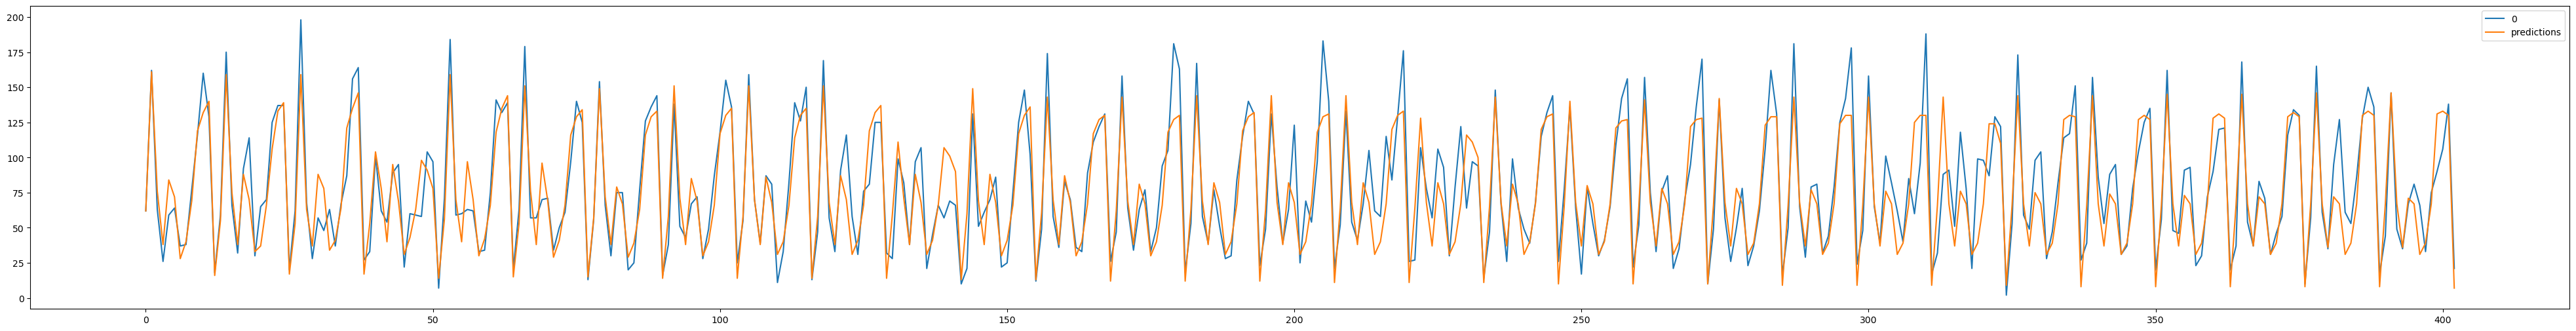

In [54]:
scaled_daily_test2.plot(kind = 'line',figsize =(50,6))

rmse = sqrt(mean_squared_error(scaled_daily_test2[0],scaled_daily_test2['predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(scaled_daily_test2))*np.sum(np.abs((scaled_daily_test2[0]-scaled_daily_test2['predictions'])/scaled_daily_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_daily_test2[0]/np.sum(scaled_daily_test2[0]))*(np.abs((scaled_daily_test2[0]-scaled_daily_test2['predictions'])/scaled_daily_test2[0])))*100
print('wmape:',wmape)

# WEEKLY TREND CHARECTERISTICS

In [55]:
n_input_weekly = 6
n_features = 1
def weekly_train_data(a,n):
    U,v=[],[]
    for i in range(len(a)-91):
        end_ix = i +91*n
        if end_ix > len(a)-1:
            break
        seq_u,seq_v = [a[i+91*j] for j in range(n)],a[end_ix]
        U.append(seq_u)
        v.append(seq_v)
    return np.array(U),np.array(v)
U,v = weekly_train_data(scaled_hourly_train,n_input_weekly)
U_train,U_val,v_train,v_val =train_test_split(U,v,test_size=0.15,shuffle = False,random_state = 0)

In [56]:
U[0],v[0]

(array([[0.11637931],
        [0.0387931 ],
        [0.13362069],
        [0.37068966],
        [0.32758621],
        [0.40086207]]),
 array([0.28448276]))

In [31]:
model3 =Sequential()
model3.add(LSTM(128,activation ='relu',input_shape=(n_input_weekly,n_features),return_sequences=True))#return sequence when more than one layer
##model3.add(Dropout(0.2))
model3.add(LSTM(64,return_sequences=True))
##model3.add(Dropout(0.2))
model3.add(LSTM(16))
model3.add(Dense(1))

In [32]:
#model compiling
model3.compile(optimizer = 'adam',loss = 'mse')
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 6, 128)            66560     
                                                                 
 lstm_10 (LSTM)              (None, 6, 64)             49408     
                                                                 
 lstm_11 (LSTM)              (None, 16)                5184      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 121,169
Trainable params: 121,169
Non-trainable params: 0
_________________________________________________________________


In [33]:
model3.fit(U_train,v_train,validation_data = (U_val,v_val),epochs = 100,batch_size = 32)

Epoch 1/100
101/101 [==============================] - 5s 13ms/step - loss: 0.0157 - val_loss: 0.0084
Epoch 2/100
101/101 [==============================] - 1s 8ms/step - loss: 0.0071 - val_loss: 0.0090
Epoch 3/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0068 - val_loss: 0.0087
Epoch 4/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0068 - val_loss: 0.0086
Epoch 5/100
101/101 [==============================] - 1s 8ms/step - loss: 0.0069 - val_loss: 0.0087
Epoch 6/100
101/101 [==============================] - 1s 8ms/step - loss: 0.0065 - val_loss: 0.0089
Epoch 7/100
101/101 [==============================] - 1s 8ms/step - loss: 0.0066 - val_loss: 0.0081
Epoch 8/100
101/101 [==============================] - 1s 8ms/step - loss: 0.0064 - val_loss: 0.0081
Epoch 9/100
101/101 [==============================] - 1s 8ms/step - loss: 0.0065 - val_loss: 0.0080
Epoch 10/100
101/101 [==============================] - 1s 8ms/step - loss: 0.0063 - val_l

In [27]:
#model3.save('weekly_training.h5')

In [57]:
model3 = load_model('weekly_training.h5')
#19% mape, epochs 100,batch_size= 50, n_input_weekly=6,rmse 17

In [33]:
len(U),len(v),U.shape

(3796, 3796, (3796, 6, 1))

# WEEKLY PREDICTION

In [58]:
weekly_prediction_set = scaled_hourly_train[len(U):]
weekly_prediction_set

array([[0.25431034],
       [0.59482759],
       [0.20689655],
       [0.09051724],
       [0.21982759],
       [0.27155172],
       [0.17241379],
       [0.13362069],
       [0.27586207],
       [0.4612069 ],
       [0.4137931 ],
       [0.48706897],
       [0.0862069 ],
       [0.32758621],
       [0.6637931 ],
       [0.28017241],
       [0.06465517],
       [0.25862069],
       [0.34482759],
       [0.15086207],
       [0.20689655],
       [0.23275862],
       [0.40517241],
       [0.57327586],
       [0.55603448],
       [0.07327586],
       [0.24568966],
       [0.61637931],
       [0.28448276],
       [0.20258621],
       [0.19827586],
       [0.28017241],
       [0.24137931],
       [0.23275862],
       [0.35344828],
       [0.36206897],
       [0.47844828],
       [0.44827586],
       [0.19396552],
       [0.11637931],
       [0.4612069 ],
       [0.28017241],
       [0.15086207],
       [0.45258621],
       [0.43965517],
       [0.15948276],
       [0.17241379],
       [0.452

In [59]:
def training_batch_weekly(a):
    first_predict_batch = []
    for i in range(n_input_weekly):
        first_predict_batch.append(list(a[91*i]))
    first_predict_batch =np.array(first_predict_batch)
    return first_predict_batch

In [60]:
weekly_predictions = []
train_batch = training_batch_weekly(weekly_prediction_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model3.predict(current_batch)[0]
    
    # appending the prediction into array
    weekly_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    weekly_prediction_set = np.append(weekly_prediction_set[1:],current_pred)
    updated_prediction_set = weekly_prediction_set[:, np.newaxis]
    train_batch = training_batch_weekly(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)
    
weekly_predictions

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


[array([0.31372035], dtype=float32),
 array([0.6310724], dtype=float32),
 array([0.26985714], dtype=float32),
 array([0.13662817], dtype=float32),
 array([0.2612401], dtype=float32),
 array([0.29092255], dtype=float32),
 array([0.11190017], dtype=float32),
 array([0.15743068], dtype=float32),
 array([0.32563627], dtype=float32),
 array([0.5072081], dtype=float32),
 array([0.5345473], dtype=float32),
 array([0.5209521], dtype=float32),
 array([0.06140829], dtype=float32),
 array([0.24651748], dtype=float32),
 array([0.65420294], dtype=float32),
 array([0.28833386], dtype=float32),
 array([0.13827927], dtype=float32),
 array([0.27999035], dtype=float32),
 array([0.3737433], dtype=float32),
 array([0.1268672], dtype=float32),
 array([0.16564949], dtype=float32),
 array([0.2709236], dtype=float32),
 array([0.4386003], dtype=float32),
 array([0.5315904], dtype=float32),
 array([0.56327796], dtype=float32),
 array([0.07535321], dtype=float32),
 array([0.24161716], dtype=float32),
 array([0.6

In [61]:
scaled_weekly_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_weekly_test2 = pd.DataFrame(scaled_weekly_test1)
true_predictions = scaler.inverse_transform(weekly_predictions)
scaled_weekly_test2['predictions'] = np.round(true_predictions)
scaled_weekly_test2

,0,predictions
0,62.0,74.0
1,162.0,147.0
2,63.0,64.0
3,26.0,33.0
4,59.0,62.0
...,...,...
398,75.0,64.0
399,90.0,94.0
400,106.0,129.0
401,138.0,126.0


rmse: 17.402546803147292
mape: 19.807361863221406
wmape: 16.497526322466065


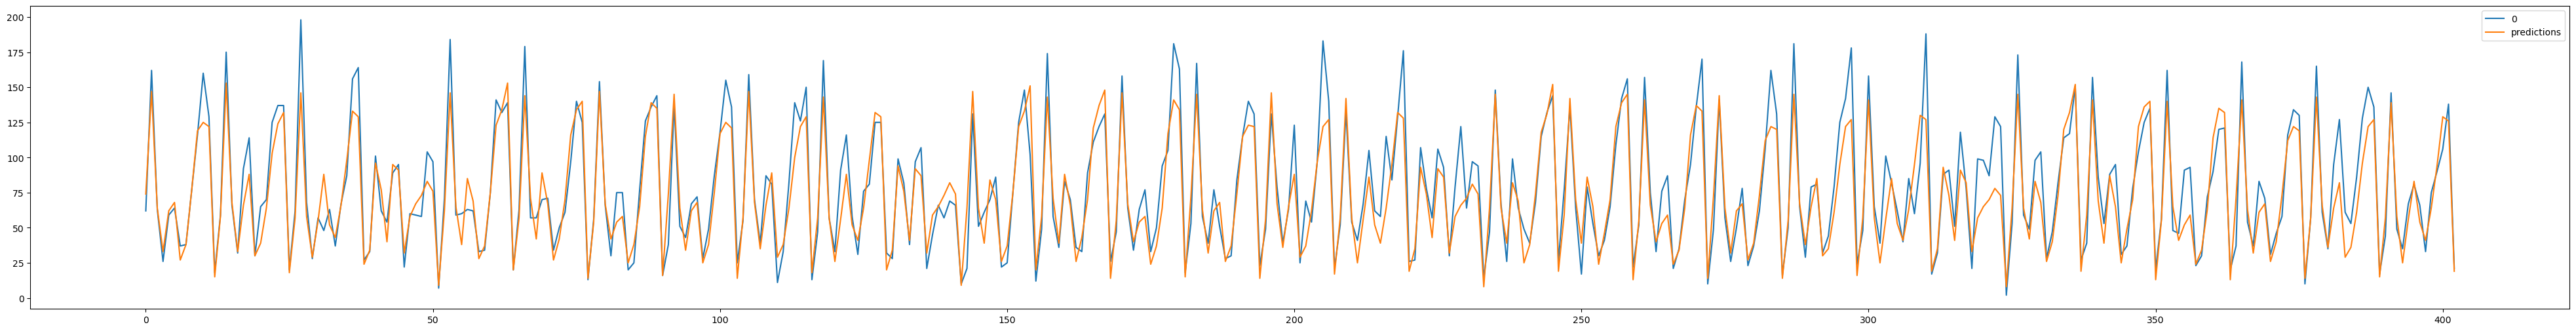

In [62]:
scaled_weekly_test2.plot(kind = 'line',figsize =(50,6))

rmse = sqrt(mean_squared_error(scaled_weekly_test2[0],scaled_weekly_test2['predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(scaled_weekly_test2))*np.sum(np.abs((scaled_weekly_test2[0]-scaled_weekly_test2['predictions'])/scaled_weekly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_weekly_test2[0]/np.sum(scaled_weekly_test2[0]))*(np.abs((scaled_weekly_test2[0]-scaled_weekly_test2['predictions'])/scaled_weekly_test2[0])))*100
print('wmape:',wmape)

In [67]:
#model3.save('weekly_training.h5')

In [63]:
scaled_hourly_test2 = scaled_hourly_test2.rename(columns = {0:'actuals'})
scaled_daily_test2 = scaled_daily_test2.rename(columns = {0:'actuals'})
scaled_weekly_test2 = scaled_weekly_test2.rename(columns = {0:'actuals'})

In [64]:
scaled_hourly_test2.to_parquet('predictions and actuals_hourly.parquet')
scaled_daily_test2.to_parquet('predictions and actuals_daily.parquet')
scaled_weekly_test2.to_parquet('predictions and actuals-weekly.parquet')

# FUSING BY STACKING
## USING NEURAL NETWORKS

In [65]:
hourly_preds = pd.read_parquet('predictions and actuals_hourly.parquet')
daily_preds = pd.read_parquet('predictions and actuals_daily.parquet')
weekly_preds = pd.read_parquet('predictions and actuals-weekly.parquet')

In [66]:
mean_squared_error(hourly_preds['actuals'],hourly_preds['predictions'])

543.8039702233251

In [67]:
##using performance weightage in weighted average method
ensemble_predictions = (0.15*hourly_preds['predictions'] + 0.15*daily_preds['predictions'] + 0.7*weekly_preds['predictions'])

In [68]:
rmse = sqrt(mean_squared_error(hourly_preds['actuals'],ensemble_predictions))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(hourly_preds))*np.sum(np.abs((hourly_preds['actuals']-ensemble_predictions)/hourly_preds['actuals']))*100
print('mape:',mape)
wmape = np.sum((hourly_preds['actuals']/np.sum(hourly_preds['actuals']))*(np.abs((hourly_preds['actuals']-ensemble_predictions)/hourly_preds['actuals'])))*100
print('wmape:',wmape)

rmse: 17.457020067233458
mape: 20.14100435405028
wmape: 16.63563998477737


In [69]:
X_train,X_val = hourly_train[['DEMAND']].iloc[:3952],hourly_train[['DEMAND']].iloc[3952:]

In [70]:
X_train,X_val = scaler.transform(X_train),scaler.transform(X_val)

In [71]:
len(X_train)-65

3887

In [72]:
val_predictions = []
first_eval_batch = X_train[-n_input_hourly:]
current_batch = first_eval_batch.reshape(1,n_input_hourly,n_features)

for i in range(len(X_val)):
    # get the prediction value for first batch
    current_pred = model1.predict(current_batch)[0]
    
    # appending the prediction into array
    val_predictions.append(current_pred)
    
    #updating the batch with the predicted value and removing the first element
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)
    
val_predictions

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


[array([0.25164914], dtype=float32),
 array([0.63827634], dtype=float32),
 array([0.26586556], dtype=float32),
 array([0.1391958], dtype=float32),
 array([0.27556682], dtype=float32),
 array([0.283086], dtype=float32),
 array([0.09824802], dtype=float32),
 array([0.14508906], dtype=float32),
 array([0.33376908], dtype=float32),
 array([0.49447384], dtype=float32),
 array([0.54531443], dtype=float32),
 array([0.47061828], dtype=float32),
 array([0.0340189], dtype=float32),
 array([0.29911196], dtype=float32),
 array([0.64992106], dtype=float32),
 array([0.22931367], dtype=float32),
 array([0.13298933], dtype=float32),
 array([0.23868512], dtype=float32),
 array([0.22554824], dtype=float32),
 array([0.12277431], dtype=float32),
 array([0.10841817], dtype=float32),
 array([0.2868072], dtype=float32),
 array([0.4027141], dtype=float32),
 array([0.5060823], dtype=float32),
 array([0.52405167], dtype=float32),
 array([0.06290209], dtype=float32),
 array([0.22371161], dtype=float32),
 array([

In [73]:
val_test1 = scaler.inverse_transform(X_val)
val_test2 = pd.DataFrame(val_test1)
true_predictions = scaler.inverse_transform(val_predictions)
val_test2['val_predictions'] = np.round(true_predictions)
val_test2

,0,val_predictions
0,48.0,59.0
1,144.0,149.0
2,57.0,63.0
3,42.0,33.0
4,59.0,65.0
...,...,...
385,45.0,69.0
386,114.0,97.0
387,132.0,118.0
388,142.0,121.0


In [74]:
rmse = sqrt(mean_squared_error(val_test2[0],val_test2['val_predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(val_test2))*np.sum(np.abs((val_test2[0]-val_test2['val_predictions'])/val_test2[0]))*100
print('mape:',mape)
wmape = np.sum((val_test2[0]/np.sum(val_test2[0]))*(np.abs((val_test2[0]-val_test2['val_predictions'])/val_test2[0])))*100
print('wmape:',wmape)

rmse: 22.954637540492435
mape: 24.811042622163804
wmape: 21.415478615071283


In [75]:
val_prediction_set = X_train[len(X_train)-91:]
val_prediction_set

array([[0.18103448],
       [0.375     ],
       [0.23275862],
       [0.29741379],
       [0.32758621],
       [0.22413793],
       [0.12068966],
       [0.10344828],
       [0.20258621],
       [0.16810345],
       [0.31465517],
       [0.23275862],
       [0.02586207],
       [0.09482759],
       [0.49568966],
       [0.32758621],
       [0.23275862],
       [0.3362069 ],
       [0.24568966],
       [0.13793103],
       [0.20258621],
       [0.30603448],
       [0.37068966],
       [0.52586207],
       [0.42672414],
       [0.09051724],
       [0.34482759],
       [0.55172414],
       [0.32758621],
       [0.19396552],
       [0.30172414],
       [0.22844828],
       [0.09051724],
       [0.15517241],
       [0.34482759],
       [0.54310345],
       [0.62931034],
       [0.40948276],
       [0.06034483],
       [0.29310345],
       [0.70689655],
       [0.27155172],
       [0.09913793],
       [0.37068966],
       [0.32758621],
       [0.12931034],
       [0.18965517],
       [0.387

In [76]:
daily_val_predictions = []
train_batch = training_batch(val_prediction_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)

for i in range(len(X_val)):
    # get the prediction value for first batch
    current_pred = model2.predict(current_batch)[0]
    
    # appending the prediction into array
    daily_val_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    val_prediction_set = np.append(val_prediction_set[1:],current_pred)
    updated_prediction_set = val_prediction_set[:, np.newaxis]
    train_batch = training_batch(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)
    
daily_val_predictions

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


[array([0.24389413], dtype=float32),
 array([0.50141144], dtype=float32),
 array([0.26476538], dtype=float32),
 array([0.18687305], dtype=float32),
 array([0.29890645], dtype=float32),
 array([0.29279685], dtype=float32),
 array([0.12949596], dtype=float32),
 array([0.19818538], dtype=float32),
 array([0.27244478], dtype=float32),
 array([0.296848], dtype=float32),
 array([0.43968123], dtype=float32),
 array([0.4246929], dtype=float32),
 array([0.07132547], dtype=float32),
 array([0.23314613], dtype=float32),
 array([0.5906925], dtype=float32),
 array([0.28490472], dtype=float32),
 array([0.17401484], dtype=float32),
 array([0.29539338], dtype=float32),
 array([0.28880352], dtype=float32),
 array([0.13507259], dtype=float32),
 array([0.19789043], dtype=float32),
 array([0.29188615], dtype=float32),
 array([0.4354434], dtype=float32),
 array([0.55045474], dtype=float32),
 array([0.47404024], dtype=float32),
 array([0.08240147], dtype=float32),
 array([0.26635954], dtype=float32),
 array

In [77]:
val_daily_test1 = scaler.inverse_transform(X_val)
val_daily_test2 = pd.DataFrame(val_daily_test1)
true_predictions = scaler.inverse_transform(daily_val_predictions)
val_daily_test2['val_predictions'] = np.round(true_predictions)
val_daily_test2

,0,val_predictions
0,48.0,58.0
1,144.0,117.0
2,57.0,62.0
3,42.0,44.0
4,59.0,70.0
...,...,...
385,45.0,67.0
386,114.0,102.0
387,132.0,130.0
388,142.0,109.0


In [78]:
rmse = sqrt(mean_squared_error(val_daily_test2[0],val_daily_test2['val_predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(val_daily_test2))*np.sum(np.abs((val_daily_test2[0]-val_daily_test2['val_predictions'])/val_daily_test2[0]))*100
print('mape:',mape)
wmape = np.sum((val_daily_test2[0]/np.sum(val_daily_test2[0]))*(np.abs((val_daily_test2[0]-val_daily_test2['val_predictions'])/val_daily_test2[0])))*100
print('wmape:',wmape)

rmse: 21.516898546884565
mape: 25.381824085259492
wmape: 20.247793618465717


In [79]:
val_weekly_pred_set = X_train[len(X_train)-546:]
val_weekly_pred_set

array([[0.22413793],
       [0.63793103],
       [0.27586207],
       [0.14224138],
       [0.28448276],
       [0.18965517],
       [0.12931034],
       [0.13793103],
       [0.23706897],
       [0.44827586],
       [0.4137931 ],
       [0.625     ],
       [0.06034483],
       [0.30172414],
       [0.62068966],
       [0.25      ],
       [0.10344828],
       [0.26724138],
       [0.25862069],
       [0.15517241],
       [0.0862069 ],
       [0.25862069],
       [0.43965517],
       [0.59051724],
       [0.49137931],
       [0.06896552],
       [0.24137931],
       [0.73275862],
       [0.24568966],
       [0.17241379],
       [0.23706897],
       [0.22844828],
       [0.09051724],
       [0.10775862],
       [0.18534483],
       [0.4612069 ],
       [0.46551724],
       [0.62068966],
       [0.04741379],
       [0.26293103],
       [0.625     ],
       [0.26293103],
       [0.14224138],
       [0.25431034],
       [0.28448276],
       [0.13362069],
       [0.11206897],
       [0.301

In [80]:
weekly_val_predictions = []
train_batch = training_batch_weekly(val_weekly_pred_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)

for i in range(len(X_val)):
    # get the prediction value for first batch
    current_pred = model3.predict(current_batch)[0]
    
    # appending the prediction into array
    weekly_val_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    val_weekly_pred_set = np.append(val_weekly_pred_set[1:],current_pred)
    updated_prediction_set = val_weekly_pred_set[:, np.newaxis]
    train_batch = training_batch_weekly(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)
    
weekly_val_predictions

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


[array([0.22505951], dtype=float32),
 array([0.5790132], dtype=float32),
 array([0.28357762], dtype=float32),
 array([0.21328789], dtype=float32),
 array([0.30763483], dtype=float32),
 array([0.2945573], dtype=float32),
 array([0.1104456], dtype=float32),
 array([0.1586998], dtype=float32),
 array([0.27468824], dtype=float32),
 array([0.3440098], dtype=float32),
 array([0.39320892], dtype=float32),
 array([0.409996], dtype=float32),
 array([0.06017516], dtype=float32),
 array([0.210401], dtype=float32),
 array([0.558224], dtype=float32),
 array([0.28155285], dtype=float32),
 array([0.16466229], dtype=float32),
 array([0.29283273], dtype=float32),
 array([0.27332076], dtype=float32),
 array([0.12215261], dtype=float32),
 array([0.20536773], dtype=float32),
 array([0.32605848], dtype=float32),
 array([0.36357793], dtype=float32),
 array([0.50156176], dtype=float32),
 array([0.49934107], dtype=float32),
 array([0.07727807], dtype=float32),
 array([0.26058108], dtype=float32),
 array([0.59

In [81]:
val_weekly_test1 = scaler.inverse_transform(X_val)
val_weekly_test2 = pd.DataFrame(val_weekly_test1)
true_predictions = scaler.inverse_transform(weekly_val_predictions)
val_weekly_test2['val_predictions'] = np.round(true_predictions)
val_weekly_test2

,0,val_predictions
0,48.0,53.0
1,144.0,135.0
2,57.0,67.0
3,42.0,50.0
4,59.0,72.0
...,...,...
385,45.0,72.0
386,114.0,79.0
387,132.0,111.0
388,142.0,112.0


In [82]:
rmse = sqrt(mean_squared_error(val_weekly_test2[0],val_weekly_test2['val_predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(val_weekly_test2))*np.sum(np.abs((val_weekly_test2[0]-val_weekly_test2['val_predictions'])/val_weekly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((val_weekly_test2[0]/np.sum(val_weekly_test2[0]))*(np.abs((val_weekly_test2[0]-val_weekly_test2['val_predictions'])/val_weekly_test2[0])))*100
print('wmape:',wmape)

rmse: 22.24375452536319
mape: 23.560748734653387
wmape: 20.319076714188732


In [83]:
hourly_val_preds = scaler.transform(val_test2[['val_predictions']])
daily_val_preds = scaler.transform(val_daily_test2[['val_predictions']])
weekly_val_preds = scaler.transform(val_weekly_test2[['val_predictions']])

C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- val_predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- val_predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- val_predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(mess

In [84]:
X_val_preds = np.vstack((hourly_val_preds.flatten(), daily_val_preds.flatten(), weekly_val_preds.flatten())).T
X_val_preds.shape

(390, 3)

#  FUSING USING NEURAL NETWORKS

In [13]:
hourly_preds = pd.read_parquet('predictions and actuals_hourly.parquet')
daily_preds = pd.read_parquet('predictions and actuals_daily.parquet')
weekly_preds = pd.read_parquet('predictions and actuals-weekly.parquet')

In [24]:
hourly_test_preds = scaler.transform(hourly_preds[['predictions']])
daily_test_preds = scaler.transform(daily_preds[['predictions']])
weekly_test_preds = scaler.transform(weekly_preds[['predictions']])

C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureW

In [25]:
X_test_preds = np.vstack((hourly_test_preds.flatten(), daily_test_preds.flatten(), weekly_test_preds.flatten())).T
X_test_preds.shape

(403, 3)

In [132]:
fuse_model = Sequential()
fuse_model.add(LSTM(96,activation ='relu',input_shape=(3,n_features),return_sequences=True))#return sequence when more than one layer
fuse_model.add(LSTM(54,return_sequences=True))
fuse_model.add(LSTM(16))
fuse_model.add(Dense(1))
fuse_model.compile(loss='mse', optimizer='adam')

In [133]:
fuse_model.fit(X_val_preds, X_val, epochs=150, batch_size=10)#150+25+25

Epoch 1/150
39/39 [==============================] - 3s 3ms/step - loss: 0.0679
Epoch 2/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 3/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 4/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 5/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 6/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 7/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 8/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 9/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 10/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 11/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 12/150
39/39 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 13/150
39/39 [=================

In [26]:
fuse_predictions = fuse_model.predict(X_test_preds)

13/13 [==============================] - 0s 3ms/step


In [27]:
fused_preds = scaler.inverse_transform(fuse_predictions)
X_test = scaler.inverse_transform(scaled_hourly_test)
fusing = pd.DataFrame(X_test)
fusing['fused_preds'] = np.round(fused_preds)
fusing

,0,fused_preds
0,62.0,68.0
1,162.0,157.0
2,63.0,66.0
3,26.0,30.0
4,59.0,67.0
...,...,...
398,75.0,67.0
399,90.0,127.0
400,106.0,143.0
401,138.0,139.0


rmse: 17.89880570478288
mape: 20.914952536508054
wmape: 17.258657871368772
smape: 20.879522778772703


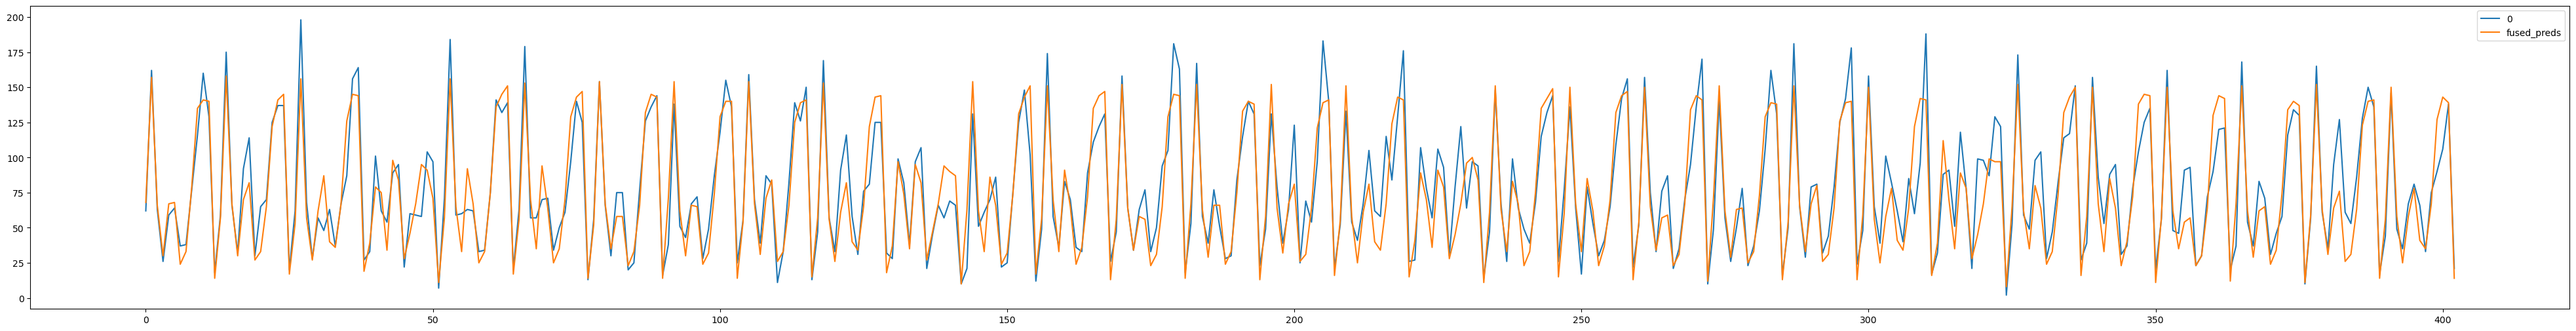

In [29]:
fusing.plot(kind = 'line',figsize =(50,6))
rmse = sqrt(mean_squared_error(fusing[0],fusing['fused_preds']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(fusing))*np.sum(np.abs((fusing[0]-fusing['fused_preds'])/fusing[0]))*100
print('mape:',mape)
wmape = np.sum((fusing[0]/np.sum(fusing[0]))*(np.abs((fusing[0]-fusing['fused_preds'])/fusing[0])))*100
print('wmape:',wmape)
smape = (2/len(fusing))*np.sum(np.abs(fusing[0]-fusing['fused_preds'])/(fusing[0]+fusing['fused_preds']))*100
print('smape:',smape)

In [420]:
#fuse_model.save('fused_model.h5')

In [18]:
fuse_model = load_model('fused_model.h5')
##mape = 20% epochs = 225, batch_size = 10,lstm 128,64,16 layers and output layer

# Prediction using weather data

In [4]:
df1 = pd.read_parquet('kelusankahourly_2022_along with rainfall.parquet')
df1.head(5)

,ETD_DATE,ETD_TD_TIME,DEMAND,RAINFALL
0,2022-01-01,7,28,0.0
1,2022-01-01,8,70,0.0
2,2022-01-01,9,22,0.0
3,2022-01-01,10,14,0.0
4,2022-01-01,11,58,0.0


In [5]:
rf_train,rf_test,demand_train,demand_test = df1[['RAINFALL']].iloc[:4342],df1[['RAINFALL']].iloc[4342:],df1[['DEMAND']].iloc[:4342],df1[['DEMAND']].iloc[4342:]
#hourly_train,hourly_test
print(len(rf_train),len(demand_test))

4342 403


In [6]:
norm1 = MinMaxScaler()
norm1.fit(rf_train)
norm_rf_train = norm1.transform(rf_train)
norm_rf_test = norm1.transform(rf_test)

norm2 = MinMaxScaler()
norm2.fit(demand_train)
norm_dem_train = norm2.transform(demand_train)
norm_dem_test = norm2.transform(demand_test)
len(norm_rf_train)

4342

In [7]:
model4 = Sequential()
model4.add(Dense(128, activation="relu", input_dim=1))
model4.add(Dense(64,activation = 'relu'))
model4.add(Dense(16,activation = 'relu'))
model4.add(Dense(1))

model4.compile(loss="mean_squared_error", optimizer="adam")

model4.fit(norm_rf_train,norm_dem_train, epochs=50)

Epoch 1/50
136/136 [==============================] - 1s 816us/step - loss: 0.0384
Epoch 2/50
136/136 [==============================] - 0s 824us/step - loss: 0.0325
Epoch 3/50
136/136 [==============================] - 0s 787us/step - loss: 0.0325
Epoch 4/50
136/136 [==============================] - 0s 838us/step - loss: 0.0325
Epoch 5/50
136/136 [==============================] - 0s 817us/step - loss: 0.0324
Epoch 6/50
136/136 [==============================] - 0s 824us/step - loss: 0.0324
Epoch 7/50
136/136 [==============================] - 0s 846us/step - loss: 0.0323
Epoch 8/50
136/136 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 9/50
136/136 [==============================] - 0s 961us/step - loss: 0.0323
Epoch 10/50
136/136 [==============================] - 0s 861us/step - loss: 0.0324
Epoch 11/50
136/136 [==============================] - 0s 868us/step - loss: 0.0325
Epoch 12/50
136/136 [==============================] - 0s 883us/step - loss: 0.0325
Epo

In [8]:
predictions = model4.predict(norm_rf_test)

13/13 [==============================] - 0s 831us/step


In [9]:
predictions = norm2.inverse_transform(predictions)

weather = pd.DataFrame(predictions)
actuals = norm2.inverse_transform(norm_dem_test)
weather['actuals'] = actuals
weather.head()

,0,actuals
0,63.012005,62.0
1,63.012005,162.0
2,63.012005,63.0
3,63.012005,26.0
4,63.012005,59.0


mape: 57.92950239418525
smape: 50.34434623786278


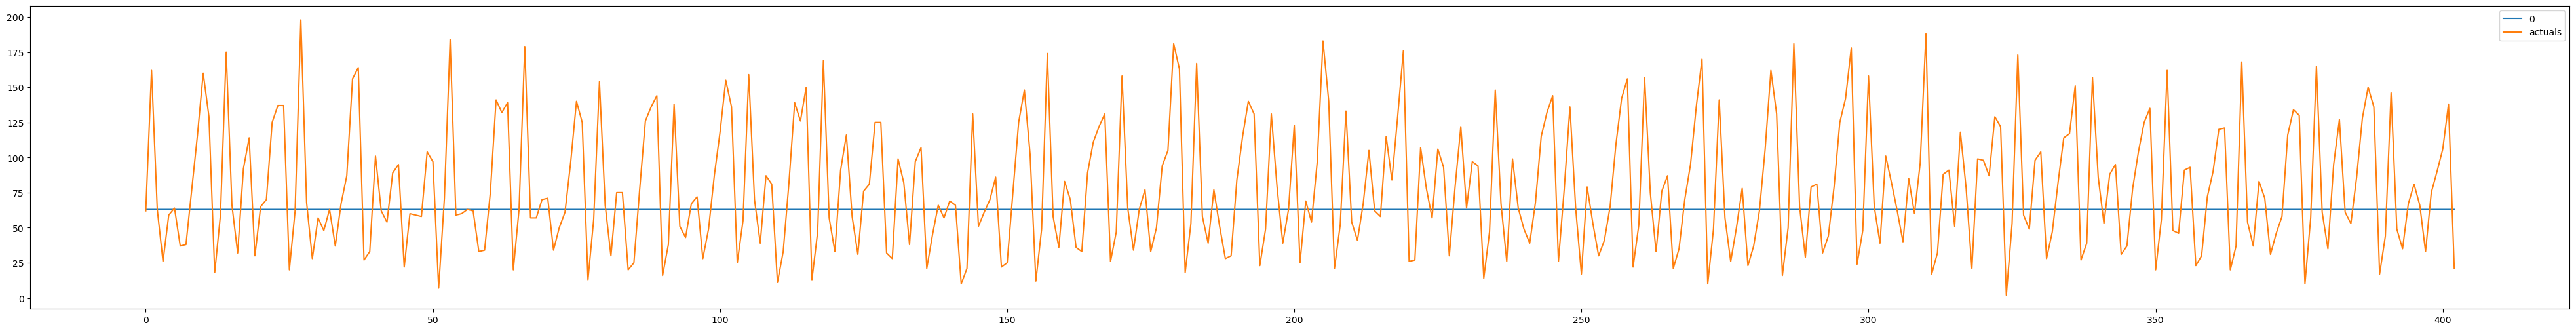

In [12]:
weather.plot(kind = 'line',figsize = (50,6))
mape = (1/len(weather))*np.sum(np.abs((weather[0]-weather['actuals'])/weather[0]))*100
smape = (2/len(weather)*np.sum(np.abs(weather[0]-weather['actuals'])/(weather[0]+weather['actuals'])))*100
print('mape:',mape)
print('smape:',smape)